In [23]:
#hello world

In [24]:
# Declare the variable
file_name = 'fake_data.csv'

In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from datetime import datetime

def analyze_monthly_spending(csv_file, month_days=None, output_path=None):
    """
    Analyze monthly spending data and project future spending
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing financial data
    month_days : int, optional
        Number of days in the month being analyzed. If None, will be determined from data
    output_path : str, optional
        Path to save visualizations. If None, will display without saving
        
    Returns:
    --------
    dict
        Dictionary containing analysis results
    """
    # Load monthly data
    monthly_data = pd.read_csv(csv_file)
    monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])
    
    # Determine days in month if not provided
    if month_days is None:
        # Get the month from the data
        current_month = monthly_data['Date'].dt.month.value_counts().idxmax()
        current_year = monthly_data['Date'].dt.year.value_counts().idxmax()
        
        # Calculate days in this month
        if current_month in [4, 6, 9, 11]:
            month_days = 30
        elif current_month == 2:
            # Check for leap year
            if (current_year % 4 == 0 and current_year % 100 != 0) or (current_year % 400 == 0):
                month_days = 29
            else:
                month_days = 28
        else:
            month_days = 31
    
    # Add day-of-month and day-of-week features
    monthly_data['day'] = monthly_data['Date'].dt.day
    monthly_data['day_of_week'] = monthly_data['Date'].dt.dayofweek
    monthly_data['day_name'] = monthly_data['Date'].dt.day_name()

    # Analyze spending by day
    daily_spending = monthly_data.groupby('day')['Debit'].sum().reset_index()
    
    # Calculate cumulative spending
    daily_spending['cumulative'] = daily_spending['Debit'].cumsum()
    
    # Initialize results dictionary
    results = {
        "total_spending": daily_spending['Debit'].sum(),
        "daily_average": daily_spending['Debit'].mean(),
        "transaction_count": len(monthly_data),
        "days_analyzed": len(daily_spending),
        "highest_day": daily_spending.loc[daily_spending['Debit'].idxmax(), 'day']
    }
    
    # Simple prediction for remaining days (if not end of month)
    current_day = daily_spending['day'].max()
    
    if current_day < month_days:
        # Fit a simple trend line to existing data
        X = daily_spending[['day']]
        y = daily_spending['cumulative']
        model = LinearRegression().fit(X, y)
        
        # Predict for remaining days
        future_days = np.array(range(current_day + 1, month_days + 1)).reshape(-1, 1)
        predicted_cumulative = model.predict(future_days)
        
        # Projected spending at month end
        projected_total = predicted_cumulative[-1]
        additional_spending = projected_total - daily_spending['cumulative'].iloc[-1]
        
        # Add projection results
        results["projected_total"] = projected_total
        results["current_spending"] = daily_spending['cumulative'].iloc[-1]
        results["projected_additional"] = additional_spending
        
        # Create visualization
        plt.figure(figsize=(10, 6))
        plt.plot(daily_spending['day'], daily_spending['cumulative'], 'bo-', label='Actual Spending')
        plt.plot(future_days, predicted_cumulative, 'ro--', label='Predicted Spending')
        plt.xlabel('Day of Month')
        plt.ylabel('Cumulative Spending ($)')
        plt.title('Monthly Spending Projection')
        plt.legend()
        plt.grid(True)
        
        if output_path:
            plt.savefig(f"{output_path}/spending_projection.png")
        else:
            plt.show()
    else:
        results["projected_total"] = daily_spending['cumulative'].iloc[-1]
        results["current_spending"] = daily_spending['cumulative'].iloc[-1]
        results["projected_additional"] = 0
    
    # Category-based analysis
    category_spending = monthly_data.groupby('category')['Debit'].agg(['sum', 'count', 'mean']).reset_index()
    category_spending = category_spending.sort_values('sum', ascending=False)
    
    # Add category insights
    results["top_categories"] = category_spending.head(3)[['category', 'sum']].to_dict('records')
    results["category_breakdown"] = category_spending.to_dict('records')
    
    # Day of week analysis
    day_of_week_spending = monthly_data.groupby(['day_of_week', 'day_name'])['Debit'].sum().reset_index()
    day_of_week_spending = day_of_week_spending.sort_values('day_of_week')
    results["day_of_week_spending"] = day_of_week_spending.to_dict('records')
    
    # Print summary
    print(f"=== Monthly Spending Analysis ===\n")
    print(f"Current spending: ${results['current_spending']:.2f}")
    
    if current_day < month_days:
        print(f"Projected total spending by end of month: ${results['projected_total']:.2f}")
        print(f"Projected additional spending: ${results['projected_additional']:.2f}")
    else:
        print("Month is complete - no projection needed.")
    
    print("\nTop Spending Categories:")
    for idx, row in category_spending.head(3).iterrows():
        print(f"- {row['category']}: ${row['sum']:.2f} ({row['count']} transactions, avg ${row['mean']:.2f})")
    
    print("\nSpending by Day of Week:")
    for _, row in day_of_week_spending.sort_values('Debit', ascending=False).iterrows():
        print(f"- {row['day_name']}: ${row['Debit']:.2f}")
    
    # Generate weekly analysis if we have enough data
    if len(daily_spending) >= 7:
        # Add week number
        monthly_data['week'] = ((monthly_data['day'] - 1) // 7) + 1
        weekly_spending = monthly_data.groupby('week')['Debit'].sum().reset_index()
        results["weekly_spending"] = weekly_spending.to_dict('records')
        
        print("\nWeekly Spending:")
        for _, row in weekly_spending.iterrows():
            print(f"- Week {int(row['week'])}: ${row['Debit']:.2f}")
            
        # Create weekly spending visualization
        plt.figure(figsize=(10, 5))
        plt.bar(weekly_spending['week'], weekly_spending['Debit'])
        plt.xlabel('Week of Month')
        plt.ylabel('Total Spending ($)')
        plt.title('Weekly Spending Pattern')
        plt.xticks(weekly_spending['week'])
        plt.grid(axis='y')
        
        if output_path:
            plt.savefig(f"{output_path}/weekly_spending.png")
        else:
            plt.show()
    
    return results


    
    # Advanced usage with custom parameters
    # results = analyze_monthly_spending(
    #     'finances_test.csv',
    #     month_days=30,
    #     output_path='./reports'
    # )

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

def analyze_spending_reduction(
    csv_file, 
    discretionary_categories=None, 
    essential_categories=None,
    reduction_target=0.2,
    output_path=None
):
    """
    Analyze spending data and provide recommendations for reducing expenses
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing financial data
    discretionary_categories : list, optional
        List of category names considered discretionary spending
    essential_categories : list, optional
        List of category names considered essential spending
    reduction_target : float, optional
        Target percentage reduction for discretionary spending (0.2 = 20%)
    output_path : str, optional
        Path to save visualizations. If None, will display without saving
        
    Returns:
    --------
    dict
        Dictionary containing analysis results and savings recommendations
    """
    # Default discretionary and essential categories if not provided
    if discretionary_categories is None:
        discretionary_categories = ['Dining', 'Entertainment', 'Shopping']
    
    if essential_categories is None:
        essential_categories = ['Groceries', 'Utilities', 'Rent', 'Bills']
    
    # Load monthly data
    monthly_data = pd.read_csv(csv_file)
    monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])
    
    # Add day of week
    monthly_data['day_of_week'] = monthly_data['Date'].dt.dayofweek
    monthly_data['day_name'] = monthly_data['Date'].dt.day_name()
    
    # Identify top spending categories
    category_totals = monthly_data.groupby('category')['Debit'].sum()
    top_categories = category_totals.sort_values(ascending=False)
    
    # Find discretionary vs. essential spending
    # Filter to only include categories that exist in the data
    existing_disc_categories = [cat for cat in discretionary_categories if cat in category_totals.index]
    existing_ess_categories = [cat for cat in essential_categories if cat in category_totals.index]
    
    # If none of the predefined categories exist in the data, identify top 3 as discretionary
    if not existing_disc_categories:
        existing_disc_categories = top_categories.head(3).index.tolist()
        print(f"Warning: None of the predefined discretionary categories found. Using top 3 categories instead: {existing_disc_categories}")
    
    # Calculate discretionary and essential spending
    discretionary_spending = monthly_data[monthly_data['category'].isin(existing_disc_categories)]['Debit'].sum()
    essential_spending = monthly_data[monthly_data['category'].isin(existing_ess_categories)]['Debit'].sum()
    
    # Identify spending patterns by day of week
    spending_by_day = monthly_data.groupby(['day_of_week', 'day_name'])['Debit'].sum().reset_index()
    spending_by_day = spending_by_day.sort_values('day_of_week')
    
    # Calculate potential savings
    potential_savings = discretionary_spending * reduction_target
    
    # Create result dictionary
    results = {
        "total_spending": monthly_data['Debit'].sum(),
        "discretionary_spending": discretionary_spending,
        "essential_spending": essential_spending,
        "potential_savings": potential_savings,
        "discretionary_categories": existing_disc_categories,
        "category_breakdown": top_categories.to_dict(),
        "spending_by_day": spending_by_day.set_index('day_name')['Debit'].to_dict(),
        "savings_recommendations": []
    }
    
    # Generate visualization of spending distribution and savings targets
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Pie chart of spending categories
    if len(top_categories) > 0:
        # Create custom labels with both percentage and amount
        def make_autopct(values):
            def my_autopct(pct):
                total = sum(values)
                val = pct*total/100.0
                return f'{pct:.1f}%\n(${val:.2f})'
            return my_autopct
    
        top_categories.head(5).plot.pie(autopct=make_autopct(top_categories.head(5)), ax=ax1)
        ax1.set_title('Top 5 Spending Categories')
        ax1.set_ylabel('')
    
    # Bar chart of day-of-week spending patterns
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    spending_by_dow = spending_by_day.set_index('day_name')['Debit']
    spending_by_dow = spending_by_dow.reindex(day_order, fill_value=0)
    
    if not spending_by_dow.empty:
        spending_by_dow.plot.bar(ax=ax2)
        ax2.set_title('Spending by Day of Week')
        ax2.set_xlabel('')
        ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Save or display visualization
    if output_path:
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(f"{output_path}/spending_distribution.png")
    else:
        plt.show()
    
    # Generate savings recommendations for each discretionary category
    category_savings = []
    for category in existing_disc_categories:
        cat_total = monthly_data[monthly_data['category'] == category]['Debit'].sum()
        suggested_reduction = cat_total * reduction_target
        target_amount = cat_total - suggested_reduction
        
        category_savings.append({
            "category": category,
            "current_amount": cat_total,
            "target_amount": target_amount,
            "savings": suggested_reduction
        })
    
    results["category_savings"] = category_savings
    
    # Find high-spending days
    average_daily = spending_by_day['Debit'].mean()
    high_spending_days = []
    
    for _, row in spending_by_day.iterrows():
        if row['Debit'] > average_daily:
            high_spending_days.append({
                "day": row['day_name'],
                "amount": row['Debit'],
                "above_average": row['Debit'] - average_daily
            })
    
    results["high_spending_days"] = high_spending_days
    
    # Print savings recommendations
    print("=== Spending Reduction Analysis ===\n")
    print(f"Current monthly total: ${results['total_spending']:.2f}")
    print(f"Discretionary spending: ${discretionary_spending:.2f} ({discretionary_spending/results['total_spending']*100:.1f}% of total)")
    print(f"Essential spending: ${essential_spending:.2f} ({essential_spending/results['total_spending']*100:.1f}% of total)")
    print(f"Potential monthly savings ({reduction_target*100:.0f}% reduction in discretionary spending): ${potential_savings:.2f}")
    
    print("\nSavings Recommendations by Category:")
    for item in category_savings:
        print(f"- {item['category']}: Current ${item['current_amount']:.2f} → Target ${item['target_amount']:.2f} (Save ${item['savings']:.2f})")
    
    print("\nHigh-Spending Days to Be Cautious About:")
    for day_info in high_spending_days:
        print(f"- {day_info['day']}: ${day_info['amount']:.2f} (${day_info['above_average']:.2f} above average)")
    
    # Additional recommendations based on insights
    print("\nAdditional Strategies:")
    if high_spending_days:
        highest_day = max(high_spending_days, key=lambda x: x['amount'])
        print(f"1. Consider implementing a budget cap for {highest_day['day']}s")
    
    if len(category_savings) > 0:
        top_saving_cat = max(category_savings, key=lambda x: x['savings'])
        print(f"2. Focus on reducing {top_saving_cat['category']} expenses for biggest impact")
    
    # Week-based recommendations if we have enough data
    days_in_data = monthly_data['Date'].dt.day.nunique()
    if days_in_data >= 14:  # At least two weeks of data
        monthly_data['week'] = ((monthly_data['Date'].dt.day - 1) // 7) + 1
        weekly_spending = monthly_data.groupby('week')['Debit'].sum()
        
        if len(weekly_spending) > 1:
            weekly_average = weekly_spending.mean()
            highest_week = weekly_spending.idxmax()
            print(f"3. Your highest spending occurs in Week {highest_week} (${weekly_spending[highest_week]:.2f})")
            print(f"   Consider setting a weekly budget of ${weekly_average:.2f}")
    
    return results

# Example usage:
# if __name__ == "__main__":
#     # Basic usage
#     results = analyze_spending_reduction('finances_test.csv')
    
    # Advanced usage with custom parameters
    # results = analyze_spending_reduction(
    #     'finances_test.csv',
    #     discretionary_categories=['Dining', 'Entertainment', 'Shopping', 'Subscriptions'],
    #     essential_categories=['Groceries', 'Utilities', 'Rent', 'Transportation'],
    #     reduction_target=0.25,
    #     output_path='./reports'
    # )

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

def analyze_weekly_spending(
    csv_file, 
    discretionary_categories=None, 
    weekly_savings_target=0.10,
    daily_reduction_target=0.20,
    category_reduction_target=0.25,
    output_path=None
):
    """
    Analyze spending patterns by week and day of week, providing reduction strategies
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing financial data
    discretionary_categories : list, optional
        List of category names considered discretionary spending
    weekly_savings_target : float, optional
        Target percentage reduction for weekly spending (0.10 = 10%)
    daily_reduction_target : float, optional
        Target percentage reduction for highest spending day (0.20 = 20%)
    category_reduction_target : float, optional
        Target percentage reduction for top discretionary category (0.25 = 25%)
    output_path : str, optional
        Path to save visualizations. If None, will display without saving
        
    Returns:
    --------
    dict
        Dictionary containing analysis results and reduction strategies
    """
    # Default discretionary categories if not provided
    if discretionary_categories is None:
        discretionary_categories = ['Dining', 'Entertainment', 'Shopping']
    
    # Load monthly data
    monthly_data = pd.read_csv(csv_file)
    monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])
    
    # Add week number and day of week
    monthly_data['day_of_week'] = monthly_data['Date'].dt.dayofweek
    monthly_data['day_name'] = monthly_data['Date'].dt.day_name()
    
    # Calculate week of month (ensuring first week of month is week 1)
    # This handles the case where the first day of the month falls in the middle of a week
    try:
        # Try the isocalendar method first (newer pandas versions)
        first_day_of_month = monthly_data['Date'].dt.to_period('M').dt.start_time
        monthly_data['week_of_month'] = monthly_data['Date'].dt.isocalendar().week - \
                                        first_day_of_month.dt.isocalendar().week + 1
    except AttributeError:
        # Fallback for older pandas versions
        monthly_data['week_of_month'] = ((monthly_data['Date'].dt.day - 1) // 7) + 1
    
    # Weekly spending analysis
    weekly_spending = monthly_data.groupby('week_of_month')['Debit'].sum()
    weekly_avg = weekly_spending.mean()
    
    # Day of week analysis
    daily_spending = monthly_data.groupby(['day_of_week', 'day_name'])['Debit'].sum().reset_index()
    daily_spending = daily_spending.sort_values('day_of_week')
    daily_avg = daily_spending['Debit'].mean()
    
    # Category spending by week
    category_by_week = monthly_data.pivot_table(
        index='category', 
        columns='week_of_month', 
        values='Debit', 
        aggfunc='sum', 
        fill_value=0
    ).reset_index()
    
    # Create results dictionary
    results = {
        "total_spending": monthly_data['Debit'].sum(),
        "weekly_spending": weekly_spending.to_dict(),
        "weekly_average": weekly_avg,
        "daily_spending": daily_spending.set_index('day_name')['Debit'].to_dict(),
        "daily_average": daily_avg,
        "category_by_week": category_by_week.to_dict(),
        "high_spending_weeks": [],
        "high_spending_days": [],
    }
    
    # Create visualizations
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    
    # Weekly spending
    if not weekly_spending.empty:
        axs[0].bar(weekly_spending.index, weekly_spending.values)
        axs[0].axhline(y=weekly_avg, color='r', linestyle='-', label=f'Weekly Avg: ${weekly_avg:.2f}')
        axs[0].set_xlabel('Week of Month')
        axs[0].set_ylabel('Total Spending ($)')
        axs[0].set_title('Weekly Spending Pattern')
        axs[0].legend()
    
    # Daily spending
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    # Create a mapping from day_name to Debit for easy plotting in correct order
    day_mapping = daily_spending.set_index('day_name')['Debit'].to_dict()
    # Get values for all days, using 0 for days not in the data
    day_values = [day_mapping.get(day, 0) for day in day_order]
    
    axs[1].bar(day_order, day_values)
    axs[1].set_xlabel('Day of Week')
    axs[1].set_ylabel('Total Spending ($)')
    axs[1].set_title('Spending by Day of Week')
    axs[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Save or display visualization
    if output_path:
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        plt.savefig(f"{output_path}/weekly_analysis.png")
    else:
        plt.show()
    
    # Find high-spending weeks
    high_weeks = []
    for week, amount in weekly_spending.items():
        if amount > weekly_avg:
            # Find categories driving higher spending
            high_week_categories = monthly_data[monthly_data['week_of_month'] == week].groupby('category')['Debit'].sum().sort_values(ascending=False).head(3)
            
            high_weeks.append({
                "week": int(week),
                "amount": amount,
                "above_average": amount - weekly_avg,
                "top_categories": high_week_categories.to_dict()
            })
    
    results["high_spending_weeks"] = high_weeks
    
    # Find high-spending days
    high_days = []
    for _, row in daily_spending.sort_values('Debit', ascending=False).iterrows():
        day_name = row['day_name']
        amount = row['Debit']
        
        if amount > daily_avg:
            # Find categories driving higher spending on this day
            day_categories = monthly_data[monthly_data['day_name'] == day_name].groupby('category')['Debit'].sum().sort_values(ascending=False).head(3)
            
            high_days.append({
                "day": day_name,
                "amount": amount,
                "above_average": amount - daily_avg,
                "top_categories": day_categories.to_dict()
            })
    
    results["high_spending_days"] = high_days
    
    # Calculate reduction strategies
    target_weekly_saving = weekly_avg * weekly_savings_target
    results["weekly_savings_target"] = target_weekly_saving
    
    # Focus on highest day for reduction
    if not daily_spending.empty:
        highest_day = daily_spending.sort_values('Debit', ascending=False).iloc[0]
        highest_day_name = highest_day['day_name']
        highest_day_amount = highest_day['Debit']
        
        results["day_reduction_strategy"] = {
            "day": highest_day_name,
            "current_amount": highest_day_amount,
            "target_amount": highest_day_amount * (1 - daily_reduction_target),
            "savings": highest_day_amount * daily_reduction_target
        }
    
    # Get top discretionary category
    discretionary_cats_in_data = [cat for cat in discretionary_categories if cat in monthly_data['category'].unique()]
    
    if discretionary_cats_in_data:
        disc_spending = monthly_data[monthly_data['category'].isin(discretionary_cats_in_data)]
        if not disc_spending.empty:
            top_disc = disc_spending.groupby('category')['Debit'].sum().sort_values(ascending=False).head(1)
            if not top_disc.empty:
                top_disc_cat = top_disc.index[0]
                top_disc_amount = top_disc.values[0]
                weekly_disc_amount = top_disc_amount / len(weekly_spending)  # Divide by number of weeks
                
                results["category_reduction_strategy"] = {
                    "category": top_disc_cat,
                    "total_amount": top_disc_amount,
                    "weekly_amount": weekly_disc_amount,
                    "target_weekly": weekly_disc_amount * (1 - category_reduction_target),
                    "weekly_savings": weekly_disc_amount * category_reduction_target
                }
    
    # Print the analysis results
    print("WEEKLY SPENDING INSIGHTS AND REDUCTION OPPORTUNITIES")
    print("=" * 50)
    print(f"Average weekly spending: ${weekly_avg:.2f}")
    
    # Identify high-spending weeks
    if high_weeks:
        for week_info in high_weeks:
            week = week_info["week"]
            amount = week_info["amount"]
            print(f"Week {week} spending (${amount:.2f}) exceeds weekly average by ${week_info['above_average']:.2f}")
            
            print("  Top spending categories this week:")
            for cat, cat_amount in week_info["top_categories"].items():
                print(f"  - {cat}: ${cat_amount:.2f}")
    
    print("\nDAY-OF-WEEK SPENDING PATTERNS")
    print("=" * 50)
    print(f"Average daily spending: ${daily_avg:.2f}")
    
    # Identify high-spending days
    if high_days:
        for day_info in high_days:
            day_name = day_info["day"]
            amount = day_info["amount"]
            print(f"{day_name} spending (${amount:.2f}) exceeds daily average by ${day_info['above_average']:.2f}")
            
            print(f"  Top {day_name} categories:")
            for cat, cat_amount in day_info["top_categories"].items():
                print(f"  - {cat}: ${cat_amount:.2f}")
    
    print("\nWEEKLY SPENDING REDUCTION PLAN")
    print("=" * 50)
    print(f"Weekly savings target: ${target_weekly_saving:.2f}")
    
    # Print day reduction strategy
    if "day_reduction_strategy" in results:
        day_strategy = results["day_reduction_strategy"]
        print(f"Strategy 1: Reduce {day_strategy['day']} spending by {daily_reduction_target*100:.0f}%")
        print(f"  Current: ${day_strategy['current_amount']:.2f}")
        print(f"  Target: ${day_strategy['target_amount']:.2f}")
        print(f"  Weekly Savings: ${day_strategy['savings']:.2f}")
    
    # Print category reduction strategy
    if "category_reduction_strategy" in results:
        cat_strategy = results["category_reduction_strategy"]
        print(f"\nStrategy 2: Reduce {cat_strategy['category']} spending by {category_reduction_target*100:.0f}%")
        print(f"  Current weekly: ${cat_strategy['weekly_amount']:.2f}")
        print(f"  Target weekly: ${cat_strategy['target_weekly']:.2f}")
        print(f"  Weekly Savings: ${cat_strategy['weekly_savings']:.2f}")
    
    return results

# # Example usage:
# if __name__ == "__main__":
#     # Basic usage
#     results = analyze_weekly_spending('finances_test.csv')
    
    # Advanced usage with custom parameters
    # results = analyze_weekly_spending(
    #     'finances_test.csv',
    #     discretionary_categories=['Dining', 'Entertainment', 'Shopping', 'Subscriptions'],
    #     weekly_savings_target=0.15,
    #     daily_reduction_target=0.25,
    #     category_reduction_target=0.30,
    #     output_path='./reports'
    # )

In [28]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

def add_day_week_columns(
    csv_file, 
    date_format='%m/%d/%y', 
    print_preview=True
):
    """
    Add day and week columns to financial data and save to CSV
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing financial data
    date_format : str, optional
        Format string for parsing the date column
    print_preview : bool, optional
        Whether to print a preview of the data with new columns
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with added day and week columns
    """
    # Load data
    df = pd.read_csv(csv_file)
    
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    
    # Extract day of the week and prefix with a number for sorting
    df['day'] = df['Date'].dt.dayofweek + 1  # Monday=0, so add 1 to make Monday=1
    day_map = {
        1: '1Monday',
        2: '2Tuesday',
        3: '3Wednesday',
        4: '4Thursday',
        5: '5Friday',
        6: '6Saturday',
        7: '7Sunday'
    }
    df['day'] = df['day'].map(day_map)
    
    # Calculate week of month
    # Method: Week 1 starts on the 1st of the month, Week 2 starts on the 8th, etc.
    df['week'] = ((df['Date'].dt.day - 1) // 7) + 1
    
    # Print preview if requested
    if print_preview:
        # Select columns to preview (date, day, week, description if available, debit if available)
        preview_cols = ['Date', 'day', 'week']
        
        # Add Description and Debit columns if they exist
        if 'Description' in df.columns:
            preview_cols.append('Description')
        if 'Debit' in df.columns:
            preview_cols.append('Debit')
        
        print("Original data with calculated columns:")
        print(df[preview_cols].head(10))  # Show first 10 rows
        
        if len(df) > 10:
            print(f"... and {len(df) - 10} more rows")
    
    # Generate output file name
    base_name, ext = os.path.splitext(csv_file)
    output_file = f"{base_name}_added_columns{ext}"
    
    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"\nFile '{output_file}' has been created with {len(df)} rows.")
    
    return df

# Example usage:
# if __name__ == "__main__":
#     # Basic usage
#     result_df = add_day_week_columns('finances_test.csv')
    
#     # Advanced usage with custom parameters
#     # result_df = add_day_week_columns(
#     #     'finances_test.csv',
#     #     date_format='%Y-%m-%d',
#     #     print_preview=False
#     # )

In [29]:
def print_non_onetime_rows(csv_file, output_file='recurring.csv'):
    """
    Print all rows from a CSV file where the 'kind' column is not equal to 'onetime'
    and append them to an output CSV file, removing duplicates
    
    Parameters:
    -----------
    csv_file : str
        Path to the CSV file containing financial data
    output_file : str, optional
        Path where the output CSV will be saved (default: 'recurring.csv')
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with filtered rows
    """
    # Import pandas
    import pandas as pd
    import os
    
    # Load data
    try:
        df = pd.read_csv(csv_file)
    except Exception as e:
        print(f"Error loading CSV file: {e}")
        return
    
    # Check if 'kind' column exists
    if 'kind' not in df.columns:
        print("Error: 'kind' column not found in the CSV file.")
        return
        
    # Filter rows where kind is not 'onetime'
    filtered_df = df[df['kind'] != 'onetime']
    
    # If no matching rows found
    if filtered_df.empty:
        print("No rows found where 'kind' is not 'onetime'.")
        return
    
    # Print number of rows found
    print(f"Found {len(filtered_df)} rows where 'kind' is not 'onetime':")
    print("=" * 80)
    
    # Print each row with formatting
    for idx, row in filtered_df.iterrows():
        print(f"Row {idx}:")
        for col, val in row.items():
            print(f"  {col}: {val}")
        print("-" * 50)
    
    # Calculate total of Debit column if it exists
    total_amount = 0
    if 'Debit' in filtered_df.columns:
        total_amount = filtered_df['Debit'].sum()
    
    # Print summary with total
    print(f"\nSummary: {len(filtered_df)} non-onetime entries out of {len(df)} total entries.")
    print(f"Total amount for non-onetime entries: ${total_amount:.2f}")
    
    # Check if output file exists and load it if it does
    if os.path.exists(output_file):
        print(f"\nAppending to existing file: {output_file}")
        existing_df = pd.read_csv(output_file)
        
        # Keep track of counts for reporting
        initial_count = len(existing_df)
        
        # Combine existing data with new filtered data
        combined_df = pd.concat([existing_df, filtered_df])
        
        # Drop duplicates
        combined_df = combined_df.drop_duplicates()
        
        # Save to CSV
        combined_df.to_csv(output_file, index=False)
        
        # Calculate and print stats
        final_count = len(combined_df)
        new_entries = final_count - initial_count
        print(f"Updated file with {final_count} unique entries (added {new_entries} new entries)")
    else:
        # File doesn't exist, create new file with filtered data
        print(f"\nCreating new file: {output_file}")
        filtered_df.to_csv(output_file, index=False)
        print(f"Saved {len(filtered_df)} entries to new file")
    
    # Return the filtered dataframe in case it's needed for further processing
    return filtered_df

# Example usage:
if __name__ == "__main__":
    print_non_onetime_rows(file_name)

Found 25 rows where 'kind' is not 'onetime':
Row 0:
  Date: 03/01/25
  description: Grocery Store
  category: Groceries
  kind: recurring
  Debit: 89.45
  Credit: 0
--------------------------------------------------
Row 1:
  Date: 03/01/25
  description: Monthly Rent Payment
  category: Rent
  kind: recurring
  Debit: 1450.0
  Credit: 0
--------------------------------------------------
Row 2:
  Date: 03/02/25
  description: Coffee Shop
  category: Dining
  kind: recurring
  Debit: 4.5
  Credit: 0
--------------------------------------------------
Row 3:
  Date: 03/03/25
  description: Gas Station
  category: Transportation
  kind: recurring
  Debit: 45.32
  Credit: 0
--------------------------------------------------
Row 4:
  Date: 03/04/25
  description: Online Subscription
  category: Subscriptions
  kind: recurring
  Debit: 12.99
  Credit: 0
--------------------------------------------------
Row 8:
  Date: 03/08/25
  description: Grocery Store
  category: Groceries
  kind: recurrin

/var/folders/6n/l_gv333j491gcl1vf3f3qx940000gn/T/ipykernel_51700/273516443.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])


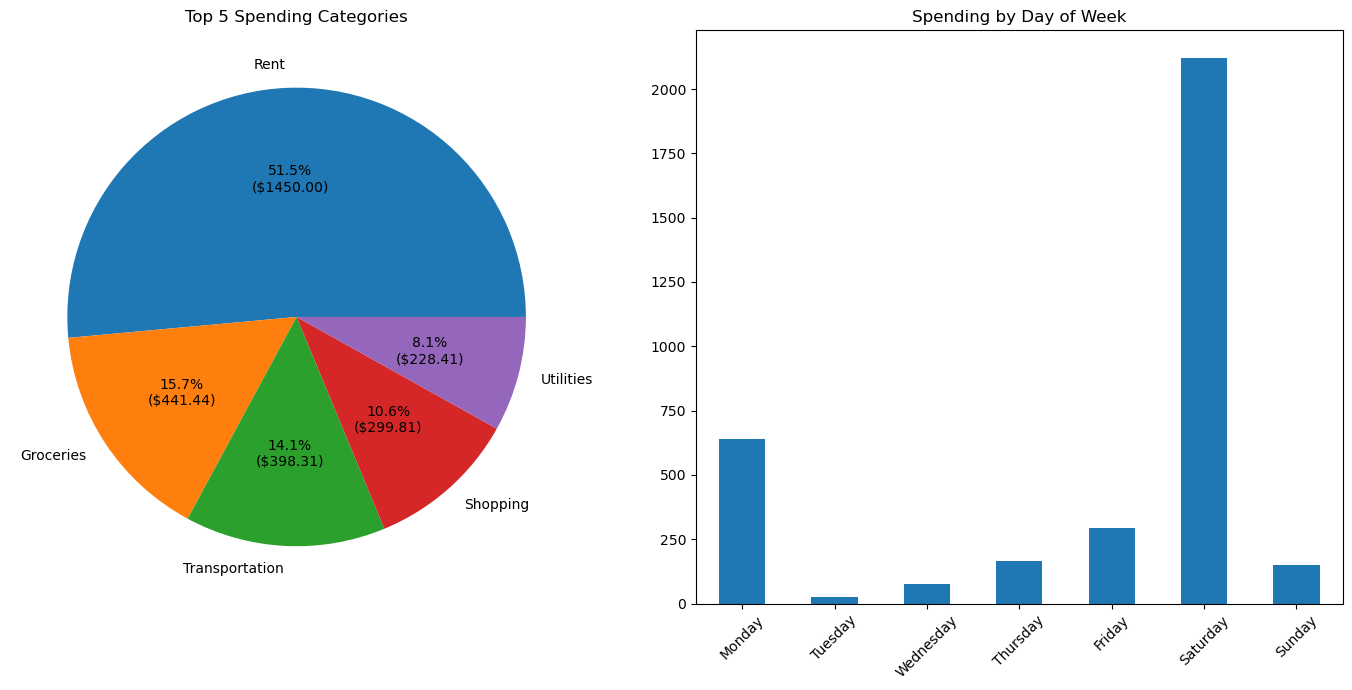

=== Spending Reduction Analysis ===

Current monthly total: $3473.07
Discretionary spending: $643.18 (18.5% of total)
Essential spending: $2204.85 (63.5% of total)
Potential monthly savings (20% reduction in discretionary spending): $128.64

Savings Recommendations by Category:
- Dining: Current $190.87 → Target $152.70 (Save $38.17)
- Entertainment: Current $152.50 → Target $122.00 (Save $30.50)
- Shopping: Current $299.81 → Target $239.85 (Save $59.96)

High-Spending Days to Be Cautious About:
- Monday: $640.67 ($144.52 above average)
- Saturday: $2122.11 ($1625.96 above average)

Additional Strategies:
1. Consider implementing a budget cap for Saturdays
2. Focus on reducing Shopping expenses for biggest impact
3. Your highest spending occurs in Week 1 ($1729.39)
   Consider setting a weekly budget of $694.61


In [30]:
# Example usage:
if __name__ == "__main__":
    # Basic usage
    results = analyze_spending_reduction(file_name)
    

/var/folders/6n/l_gv333j491gcl1vf3f3qx940000gn/T/ipykernel_51700/211573749.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_data['Date'] = pd.to_datetime(monthly_data['Date'])


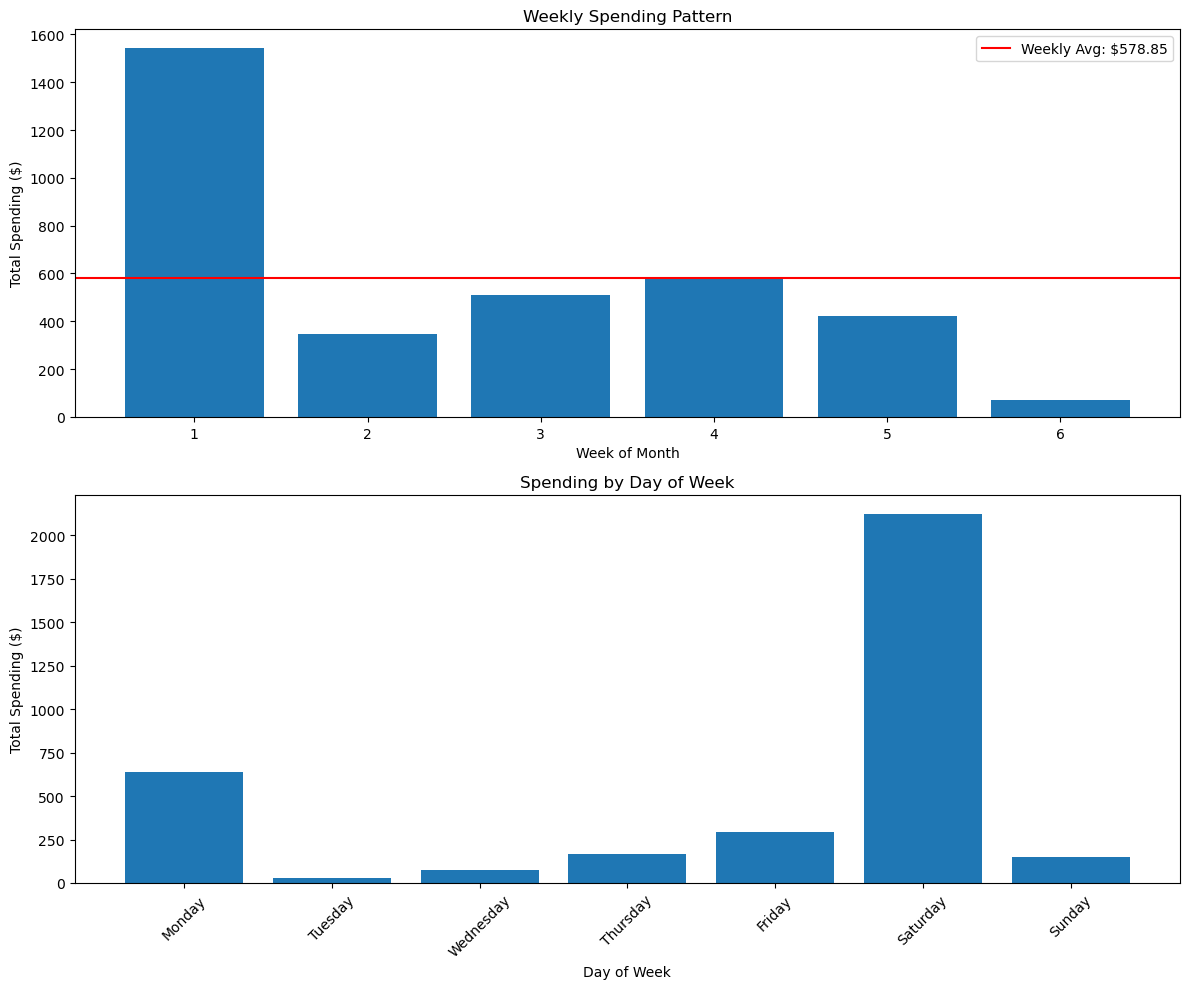

WEEKLY SPENDING INSIGHTS AND REDUCTION OPPORTUNITIES
Average weekly spending: $578.85
Week 1 spending ($1543.95) exceeds weekly average by $965.11
  Top spending categories this week:
  - Rent: $1450.00
  - Groceries: $89.45
  - Dining: $4.50
Week 4 spending ($582.49) exceeds weekly average by $3.64
  Top spending categories this week:
  - Transportation: $285.43
  - Entertainment: $120.00
  - Groceries: $105.32

DAY-OF-WEEK SPENDING PATTERNS
Average daily spending: $496.15
Saturday spending ($2122.11) exceeds daily average by $1625.96
  Top Saturday categories:
  - Rent: $1450.00
  - Groceries: $441.44
  - Utilities: $115.67
Monday spending ($640.67) exceeds daily average by $144.52
  Top Monday categories:
  - Transportation: $373.31
  - Shopping: $124.87
  - Dining: $72.50

WEEKLY SPENDING REDUCTION PLAN
Weekly savings target: $57.88
Strategy 1: Reduce Saturday spending by 20%
  Current: $2122.11
  Target: $1697.69
  Weekly Savings: $424.42

Strategy 2: Reduce Shopping spending by 2

In [31]:
# Example usage:
if __name__ == "__main__":
    # Basic usage
    results = analyze_weekly_spending(file_name)
    

In [32]:
if __name__ == "__main__":
    # Basic usage
    result_df = add_day_week_columns(file_name)

Original data with calculated columns:
        Date         day  week    Debit
0 2025-03-01   6Saturday     1    89.45
1 2025-03-01   6Saturday     1  1450.00
2 2025-03-02     7Sunday     1     4.50
3 2025-03-03     1Monday     1    45.32
4 2025-03-04    2Tuesday     1    12.99
5 2025-03-05  3Wednesday     1    28.76
6 2025-03-06   4Thursday     1    65.87
7 2025-03-07     5Friday     1    32.50
8 2025-03-08   6Saturday     2    75.68
9 2025-03-09     7Sunday     2    85.00
... and 25 more rows

File 'fake_data_added_columns.csv' has been created with 35 rows.


In [33]:
# Example usage:
if __name__ == "__main__":
    print_non_onetime_rows(file_name)

Found 25 rows where 'kind' is not 'onetime':
Row 0:
  Date: 03/01/25
  description: Grocery Store
  category: Groceries
  kind: recurring
  Debit: 89.45
  Credit: 0
--------------------------------------------------
Row 1:
  Date: 03/01/25
  description: Monthly Rent Payment
  category: Rent
  kind: recurring
  Debit: 1450.0
  Credit: 0
--------------------------------------------------
Row 2:
  Date: 03/02/25
  description: Coffee Shop
  category: Dining
  kind: recurring
  Debit: 4.5
  Credit: 0
--------------------------------------------------
Row 3:
  Date: 03/03/25
  description: Gas Station
  category: Transportation
  kind: recurring
  Debit: 45.32
  Credit: 0
--------------------------------------------------
Row 4:
  Date: 03/04/25
  description: Online Subscription
  category: Subscriptions
  kind: recurring
  Debit: 12.99
  Credit: 0
--------------------------------------------------
Row 8:
  Date: 03/08/25
  description: Grocery Store
  category: Groceries
  kind: recurrin